In [1]:
from deepdow.benchmarks import Benchmark, OneOverN, Random
from deepdow.callbacks import EarlyStoppingCallback
from deepdow.data import InRAMDataset, RigidDataLoader, prepare_standard_scaler, Scale
from deepdow.data.synthetic import sin_single
from deepdow.experiments import Run
from deepdow.layers import SoftmaxAllocator
from deepdow.losses import MeanReturns, SharpeRatio, MaximumDrawdown
from deepdow.visualize import generate_metrics_table, generate_weights_table, plot_metrics, plot_weight_heatmap
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from pypfopt import expected_returns

## Get data (returns)

In [3]:
df = pd.read_csv("data/2021Q1_Top 50_of_Mutual_Funds_20160819_to_20200115.csv", index_col=0)
returns = expected_returns.returns_from_prices(df).to_numpy()
print(returns.shape)

(827, 41)


## Split data into training and test set

In [4]:
n_timesteps, n_assets = returns.shape[0], returns.shape[1]
lookback_timesteps, gap, lookahead_timesteps = 365, 20, 365
n_samples = n_timesteps - lookback_timesteps - lookahead_timesteps - gap + 1

split_ix = int(n_samples * 0.8)
indices_train = list(range(split_ix))
# indices_test = list(range(split_ix + lookback_timesteps + lookahead_timesteps, n_samples))
indices_test = list(range(split_ix, n_samples))

print('Train range: {}:{}\nTest range: {}:{}'.format(indices_train[0], indices_train[-1],
                                                     indices_test[0], indices_test[-1]))

Train range: 0:61
Test range: 62:77


In [5]:
X_list, y_list = [], []

for i in range(lookback_timesteps, n_timesteps - lookahead_timesteps - gap + 1):
    X_list.append(returns[i - lookback_timesteps: i, :])
    y_list.append(returns[i + gap: i + gap + lookahead_timesteps, :])

X = np.stack(X_list, axis=0)[:, None, ...]
y = np.stack(y_list, axis=0)[:, None, ...]

print('X: {}, y: {}'.format(X.shape, y.shape))

means, stds = prepare_standard_scaler(X, indices=indices_train)
print('mean: {}, std: {}'.format(means, stds))

X: (78, 1, 365, 41), y: (78, 1, 365, 41)
mean: [0.00090008], std: [0.02478366]


In [6]:
dataset = InRAMDataset(X, y, transform=Scale(means, stds))
# dataset = InRAMDataset(X, y)
dataloader_train = RigidDataLoader(dataset,
                                   indices=indices_train,
                                   batch_size=32)
dataloader_dev = RigidDataLoader(dataset,
                                 indices=indices_test,
                                 batch_size=32)

## Neural network definition

In [8]:
class NeuralNetwork(torch.nn.Module, Benchmark):
    def __init__(self, n_assets, lookback, p=0.5):
        super().__init__()

        n_features = n_assets * lookback

        self.dropout_layer = torch.nn.Dropout(p=p)
        self.dense_layer = torch.nn.Linear(n_features, n_assets, bias=True)
        self.allocate_layer = SoftmaxAllocator(temperature=None)
        self.temperature = torch.nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        """Perform forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Of shape (n_samples, 1, lookback, n_assets).

        Returns
        -------
        weights : torch.Torch
            Tensor of shape (n_samples, n_assets).

        """
        n_samples, _, _, _ = x.shape
        x = x.view(n_samples, -1)  # flatten features
        x = self.dropout_layer(x)
        x = self.dense_layer(x)

        temperatures = torch.ones(n_samples).to(device=x.device, dtype=x.dtype) * self.temperature
        weights = self.allocate_layer(x, temperatures)

        return weights

network = NeuralNetwork(n_assets, lookback_timesteps)
print(network)

NeuralNetwork(
  (dropout_layer): Dropout(p=0.5, inplace=False)
  (dense_layer): Linear(in_features=14965, out_features=41, bias=True)
  (allocate_layer): SoftmaxAllocator(
    (layer): Softmax(dim=1)
  )
)


## Model training

In [9]:
network = network.train()  # it is the default, however, just to make the distinction clear

loss = MaximumDrawdown() + 2 * MeanReturns() + SharpeRatio()
run = Run(network,
          loss,
          dataloader_train,
          val_dataloaders={'val': dataloader_dev},
          optimizer=torch.optim.Adam(network.parameters(), amsgrad=True),
          callbacks=[EarlyStoppingCallback(metric_name='loss',
                                           dataloader_name='val',
                                           patience=15)])
history = run.launch(100)
per_epoch_results = history.metrics.groupby(['dataloader', 'metric', 'model', 'epoch'])['value']

print(per_epoch_results.count())  # double check number of samples each epoch
print(per_epoch_results.mean())  # mean loss per epoch

Epoch 56: 100%|██████████████████████████████████████████| 2/2 [00:00<00:00, 10.18it/s, loss=0.08996, val_loss=0.06413]


Training interrupted
Training stopped early because there was no improvement in val_loss for 15 epochs
dataloader  metric  model    epoch
val         loss    network  0        16
                             1        16
                             2        16
                             3        16
                             4        16
                             5        16
                             6        16
                             7        16
                             8        16
                             9        16
                             10       16
                             11       16
                             12       16
                             13       16
                             14       16
                             15       16
                             16       16
                             17       16
                             18       16
                             19       16
                             20       16
 

array([<AxesSubplot:title={'center':'MaximumDrawdown'}, xlabel='timestamp'>,
       <AxesSubplot:title={'center':'Sharpe'}, xlabel='timestamp'>,
       <AxesSubplot:title={'center':'MeanReturn'}, xlabel='timestamp'>],
      dtype=object)

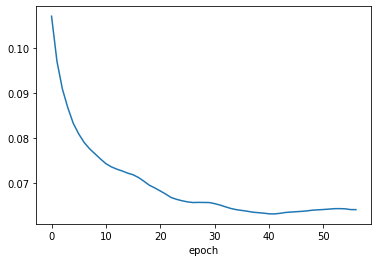

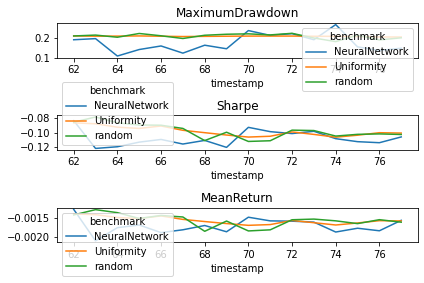

In [10]:
per_epoch_results.mean()['val']['loss']['network'].plot()
network = network.eval()
benchmarks = {
    'Uniformity': OneOverN(),  # each asset has weight 1 / n_assets
    'random': Random(),  # random allocation that is however close 1OverN
    'NeuralNetwork': network
}
metrics = {
    'MaximumDrawdown': MaximumDrawdown(),
    'Sharpe': SharpeRatio(),
    'MeanReturn': MeanReturns()
}

metrics_table = generate_metrics_table(benchmarks,
                                       dataloader_dev,
                                       metrics)
plot_metrics(metrics_table)

## evaluation

In [11]:
X_for_test = returns[-lookback_timesteps:, :][None, None, :, ...]
means = X_for_test.mean(axis=(0, 2, 3))
stds = X_for_test.std(axis=(0, 2, 3))
print('mean: {}, std: {}'.format(means, stds))
X_for_test = torch.tensor(X_for_test, dtype=torch.float)
X_for_test, _, _, _ = Scale(means, stds)(X_for_test, None, None, None)
predicted_weight = network(X_for_test).detach().numpy().tolist()[0]
predicted_weight = np.round(predicted_weight, 5)
predicted_weight = pd.DataFrame(predicted_weight, index=list(df.columns))
predicted_weight.to_csv("results/weights_NN.csv", header=False)
print(predicted_weight)

mean: [0.00129271], std: [0.02496246]
            0
贵州茅台  0.02351
五粮液   0.00361
海康威视  0.00138
中国中免  0.03274
招商银行  0.01425
泸州老窖  0.00358
中国平安  0.03389
隆基股份  0.00932
美的集团  0.00482
长春高新  0.01306
山西汾酒  0.00258
兴业银行  0.01111
伊利股份  0.00851
恒瑞医药  0.00725
智飞生物  0.01476
三一重工  0.11057
亿纬锂能  0.02844
万科A   0.00848
平安银行  0.00515
东方财富  0.04347
宁波银行  0.35383
万华化学  0.00229
分众传媒  0.00154
顺丰控股  0.00801
汇川技术  0.00963
爱尔眼科  0.01727
海尔智家  0.00495
赣锋锂业  0.01126
洋河股份  0.02085
立讯精密  0.01830
紫金矿业  0.01004
格力电器  0.00747
东方雨虹  0.02573
泰格医药  0.00188
京东方A  0.00269
中信证券  0.01307
海大集团  0.09998
荣盛石化  0.00623
兆易创新  0.00050
华友钴业  0.00289
紫光国微  0.00112


<AxesSubplot:>

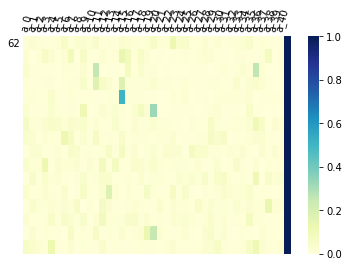

In [12]:
weight_table = generate_weights_table(network, dataloader_dev)
plot_weight_heatmap(weight_table,
                    add_sum_column=True,
                    time_format=None,
                    time_skips=25)